<a href="https://colab.research.google.com/github/NewCodeLearner/DeepLearning_PyTorch/blob/main/ConvolutionalNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CNN's are neural networks that are used to classify images.

We'll look at the Mnist Dataset and I'll explain a broad overview of how CNN's work.

MNIST Dataset comes with 50000 training set and 10000 test images set

setosa.io/image for demo of CNN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Convert MNIST image file into Tensor of 4-dimensions (# of images, ht,width,color channel)
transform = transforms.ToTensor()

In [3]:
#Train data Download and save the MNIST data into local directory
train_data = datasets.MNIST(root='/cnn_data',train =True,download=True,transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 884049.82it/s] 


Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 62403.89it/s]


Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 239450.23it/s]


Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4268547.79it/s]

Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



In [4]:
test_data = datasets.MNIST(root='/cnn_data',train=False,download=True,transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
# create a small batch size for images
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [8]:
#Define our CNN Model
#Describe convolutional layer and what its doing ( 2 Convolutional layers)
#this is just an exmaple.
conv1= nn.Conv2d(1,6,3,1)  #input size 1,output 6(feature maps),kernel size 3x3 ,stride 1 pixel at a time
conv2= nn.Conv2d(6,16,3,1) #6 output becomes input here , 16 output feature maps

In [9]:
# Grab 1 MNIST image
for i,(X_train,y_train) in enumerate(train_data):
    break

In [10]:
X_train.shape
#torch.Size([1, 28, 28]) 1 image of 28x28 size

torch.Size([1, 28, 28])

In [11]:
x = X_train.view(1,1,28,28) # 1 batch--1image--28x28 pixels

In [12]:
# Perform our first convolution
x=F.relu(conv1(x)) #rectified linear unit for activation function

In [13]:
# 1 single image , 6 the filters we asked for,
#26x26 is the image as we dont have padding and mnist data is all in the middle of the image so we are not losing any data but for other projects padding may be needed.
x.shape

torch.Size([1, 6, 26, 26])

In [14]:
# pass thru pooling layer
x=F.max_pool2d(x,2,2) # 2x2 kernel for pooling stride of 2

In [15]:
#as we set kernel 2x2 the image is now 26/2 =13
x.shape

torch.Size([1, 6, 13, 13])

In [16]:
#Do our second convolution layer
x=F.relu(conv2(x))

In [17]:
x.shape #again we didnt set padding so we lose 2 pixels around the images edges

torch.Size([1, 16, 11, 11])

In [18]:
#pooling layer
x=F.max_pool2d(x,2,2) #11/2 =5.5 but we have to round down, because we cant invent data to round up

In [19]:
x.shape

torch.Size([1, 16, 5, 5])

In [20]:
# Model Class
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1=nn.Conv2d(1,6,3,1)
      self.conv2=nn.Conv2d(6,16,3,1)
      #fully connected layer
      self.fc1= nn.Linear(5*5*16,120)
      self.fc2= nn.Linear(120,84)
      self.fc3= nn.Linear(84,10)

    #forward pass
    def forward(self,x):
      x=F.relu(self.conv1(x))
      x=F.max_pool2d(x,2,2)
      #second pass
      x=F.relu(self.conv2(x))
      x=F.max_pool2d(x,2,2)
      #re-View to flatten out
      x=x.view(-1,5*5*16) # negative one so we can vary the batch size
      #Fully connected layers
      x=F.relu(self.fc1(x))
      x=F.relu(self.fc2(x))
      x=self.fc3(x)
      return F.log_softmax(x,dim=1)

In [21]:
# create an instance of model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001) #smaller the lr the longer training will take.


Train the model

In [23]:
import time
start_time = time.time()

# Create variable to track things
epochs=5
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]

#for loop of Epochs
for i in range(epochs):
  trn_corr=0
  tst_corr=0

  #Train
  for b,(X_train,y_train) in enumerate(train_loader):
    b+=1 #start batch at 1
    y_pred = model(X_train) #its not flattened this is 2D
    loss = criterion(y_pred,y_train)#how off are we? compare prediction to correct
    predicted = torch.max(y_pred.data,1)[1] # add up the number of correct position . Indexed off the first point
    batch_corr = (predicted==y_train).sum() #how many we got correct from this specific batch.
    trn_corr +=batch_corr

    #update the parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #print out some results
    if b%600 ==0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

  train_losses.append(loss.item()) # Append the scalar value of the loss
  train_correct.append(trn_corr)

  #test
  with torch.no_grad():
      for b,(X_test,y_test) in enumerate(test_loader):
        y_val = model(X_test)
        predicted = torch.max(y_val.data,1)[1]
        tst_corr += (predicted==y_test).sum()

  loss = criterion(y_val,y_test)
  test_losses.append(loss.item())
  test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f'Training took {total/60} minutes')

Epoch: 0 Batch: 600 Loss: 0.1599934995174408
Epoch: 0 Batch: 1200 Loss: 0.18979528546333313
Epoch: 0 Batch: 1800 Loss: 0.5580862760543823
Epoch: 0 Batch: 2400 Loss: 0.2070152312517166
Epoch: 0 Batch: 3000 Loss: 0.006888664327561855
Epoch: 0 Batch: 3600 Loss: 0.33112621307373047
Epoch: 0 Batch: 4200 Loss: 0.004664934705942869
Epoch: 0 Batch: 4800 Loss: 0.0020317500457167625
Epoch: 0 Batch: 5400 Loss: 0.06558699160814285
Epoch: 0 Batch: 6000 Loss: 0.000513441045768559
Epoch: 1 Batch: 600 Loss: 0.004773168824613094
Epoch: 1 Batch: 1200 Loss: 0.30684694647789
Epoch: 1 Batch: 1800 Loss: 0.0025840331800282
Epoch: 1 Batch: 2400 Loss: 0.004851708188652992
Epoch: 1 Batch: 3000 Loss: 0.05095291882753372
Epoch: 1 Batch: 3600 Loss: 0.29904529452323914
Epoch: 1 Batch: 4200 Loss: 0.020275484770536423
Epoch: 1 Batch: 4800 Loss: 0.0018002415308728814
Epoch: 1 Batch: 5400 Loss: 0.0003511425748001784
Epoch: 1 Batch: 6000 Loss: 0.16817066073417664
Epoch: 2 Batch: 600 Loss: 0.044435493648052216
Epoch: 2 B

**Graph** **CNN** **Results**

In [24]:
train_losses[0]

0.000513441045768559

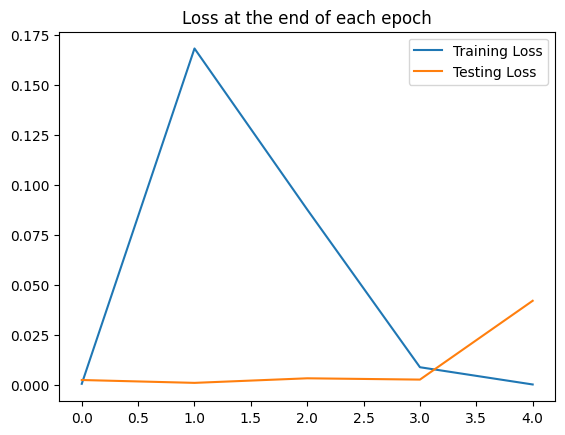

In [25]:
plt.plot(train_losses,label='Training Loss')
plt.plot(test_losses,label='Testing Loss')
plt.title('Loss at the end of each epoch')
plt.legend()

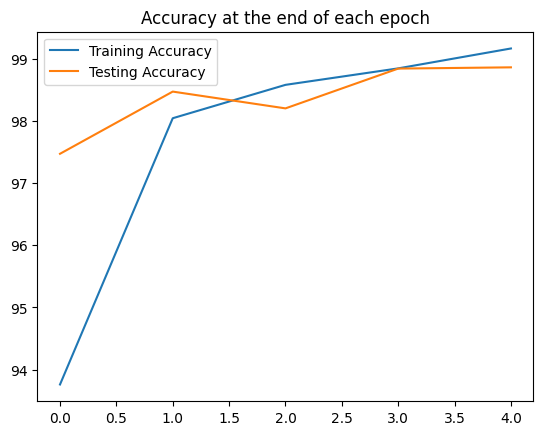

In [26]:
plt.plot([t/600 for t in train_correct])
plt.plot([t/100 for t in test_correct])
plt.title('Accuracy at the end of each epoch')
plt.legend(['Training Accuracy','Testing Accuracy'])

Send new image thru model

In [ ]:
# Grab an image
test_data[4143] # Tensor with image and label

In [28]:
# Grab just the data without the label at the end
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [ ]:
test_data[4143][0].reshape(28,28)

In [33]:
# put the image through the model
model.eval()
with torch.no_grad():
  new_pred=model(test_data[4143][0].view(1,1,28,28)) # batch size of 1 ,1 color channel, 28x28 image
  print(new_pred)

tensor([[-2.6323e+01, -2.2043e+01, -2.5815e+01, -1.6283e+01, -1.1452e+01,
         -2.2503e+01, -3.8594e+01, -1.5411e+01, -1.7841e+01, -1.0967e-05]])


In [34]:
#use argmax to check which number it predicted
new_pred.argmax() # predicted number 9

tensor(9)

In [38]:
with torch.no_grad():
  new_pred=model(test_data[2709][0].view(1,1,28,28)) # batch size of 1 ,1 color channel, 28x28 image
  print(new_pred.argmax())

tensor(4)
